# PART 3 - Metadata Knowledge Graph creation in Amazon Neptune.

Amazon Neptune is a fast, reliable, fully managed graph database service that makes it easy to build and run applications that work with highly connected datasets. The core of Neptune is a purpose-built, high-performance graph database engine. This engine is optimized for storing billions of relationships and querying the graph with milliseconds latency. Neptune supports the popular graph query languages Apache TinkerPop Gremlin and W3C’s SPARQL, enabling you to build queries that efficiently navigate highly connected datasets.

https://docs.aws.amazon.com/neptune/latest/userguide/feature-overview.html

In that section we're going to use TinkerPop Gremlin as the language to create and query our graph.

### Important
We need to downgrade the tornado library for the gremlin libraries to work in our notebook.

Without doing this, you'll most likely run into the following error when executing some gremlin queries: 
"RuntimeError: Cannot run the event loop while another loop is running"

In [2]:
!pip install --upgrade tornado==4.5.3

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


### Restart your kernel
Because the notebook itself has some dependencies with the tornado library, we need to restart the kernel before proceeding.

To do so, go to the top menu > Kernel > Restart Kernel.. > Restart

Then proceed and execute the following cells.

In [3]:
!pip install pandas
!pip install jsonlines
!pip install gremlinpython
!pip install networkx
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [4]:
import os
import jsonlines
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
#load stored variable from previous notebooks
%store -r

Loading the Gremlin libraries and connecting to our Neptune instance

In [6]:
from gremlin_python import statics
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.traversal import T
from gremlin_python.process.traversal import Order
from gremlin_python.process.traversal import Cardinality
from gremlin_python.process.traversal import Column
from gremlin_python.process.traversal import Direction
from gremlin_python.process.traversal import Operator
from gremlin_python.process.traversal import P
from gremlin_python.process.traversal import Pop
from gremlin_python.process.traversal import Scope
from gremlin_python.process.traversal import Barrier
from gremlin_python.process.traversal import Bindings
from gremlin_python.process.traversal import WithOptions
from gremlin_python.structure.graph import Graph

graph = Graph()

def start_remote_connection_neptune():
    remoteConn = DriverRemoteConnection(your_neptune_endpoint_url,'g')
    g = graph.traversal().withRemote(remoteConn)
    return g

# g is the traversal source to use to query the graph 
g = start_remote_connection_neptune()

<b>IMPORTANT:</b>
- Note that the remote connection will time out after few minutes if unused so if you're encountering exceptions after having paused the notebook execution for a while, please re-run the above cell.
- <b>Make sure your Neptune DB is created for the sole purpose of this labs as we'll be cleaning it before starting.</b>

In [7]:
#CAREFUL - the below line of code empties your graph. Again, make sure you're using a dedicated instance for this workshop
g.V().drop().iterate()

[['V'], ['drop'], ['none'], ['values', '_ipython_canary_method_should_not_exist_'], ['values', '_ipython_canary_method_should_not_exist_']]

## A note on Gremlin

Gremlin is a functional, data-flow language that enables users to succinctly express complex traversals on (or queries of) their application's property graph. Every Gremlin traversal is composed of a sequence of (potentially nested) steps. A step performs an atomic operation on the data stream. Every step is either a map-step (transforming the objects in the stream), a filter-step (removing objects from the stream), or a sideEffect-step (computing statistics about the stream).

More info here: https://tinkerpop.apache.org/gremlin.html

The image below is an extract from:
https://tinkerpop.apache.org/docs/3.5.1/tutorials/getting-started/#_the_next_fifteen_minutes

I highly recommend you to be familiar with the concepts of Vertex and Edges at the very minimum before proceeding with the notebook.

<img src='./static/gremlin-vertex-edge.png' width=1000/>

## Vertices and Edges names

See below the variables containing the labels for our vertices and edges that we'll create across the notebook.

In [8]:
#Vertex representing a  Video
V_VIDEO = "video"

#Vertex representing a "scene" e.g. SHOT, TECHNICAL_CUE
V_VIDEO_SCENE = "video_scene"

#Vertex representing a Video segment. we arbitrary split our video into 1min segments and attach metadata to the segments itselves
V_VIDEO_SEGMENT = 'video_segment'

#Edge between VIDEO and SEGMENT
E_HAS_SEGMENT = 'contains_segment'

#Edge between VIDEO and SCENE
E_HAS_SCENE = 'contains_scene'

#Edge between Scene and Segment
E_BELONG_TO_SEGMENT = 'belong_to_segment'

#Vertex representing a label extracted by Rekognition from the video
V_LABEL = 'label'

#Edge between SEGMENT and LABEL
E_HAS_LABEL = 'has_label'

#Edge between parent LABEL and child LABEL e.g. construction -> bulldozer
E_HAS_CHILD_LABEL = 'has_child_label'

#Vertex representing the NER
V_ENTITY = 'entities'

#Vertex representing the type of NER
V_ENTITY_TYPE = 'entity_type'

#Edge between ENTITY and ENTITY_TYPE
E_IS_OF_ENTITY_TYPE = 'is_of_entity_type'

#Edge between SEGMENT and ENTITY
E_HAS_ENTITY = 'has_entity'

#Vertex representing a TOPIC
V_TOPIC = 'topic'

#Vertex representing a TOPIC_TERM
V_TOPIC_TERM = 'topic_term'

#Edge between a VIDEO_SEGMENT and a TOPIC
E_HAS_TOPIC = 'has_topic'

#Edge between a TOPIC and a TOPIC_TERM
E_HAS_TERM = 'has_term'

#Vertex representing a TERM
V_TERM = 'term'

## We start by adding our video to the Graph

Note how I start with g, our traversal graph, then call the addV (V for Vertex) method and then attach properties to the new vertex. I end the line with ".next()" which will return the newly created node (similar to how an iterator would work). all method are "chained" together in one expression.

In [9]:
sample_video_vertex = g.addV(V_VIDEO).property("name", video_name).property("filename", video_file) .property('description', 'description of the video').next() 

[QUERY] We're listing all the vertices in the graph with their metadata. At this stage, we only have one.

Explanation: g.V() gets us all vertices in the graph, the .hasLabel() filters the vertices based on the vertex label(=type), the .valueMap() returns all properties for all vertices and the .toList() returns the full list. Note that you can use .next() instead of toList() to just return the next element in the list.

In [10]:
g.V().hasLabel(V_VIDEO).valueMap().toList()

[{'name': ['video_trailer_4min'],
  'description': ['description of the video'],
  'filename': ['video_trailer_4min.mp4']}]

[QUERY] Below is a different way to precisely return a vertex based on its name. 

Explanation: g.V() gives us all the vertices, .has() allows us to filter based on the name of the vertex and .next() returns the first (and only) item from the iterator. note that we haven't used .valueMap() so what is returned is the ID of the vertex.

In [11]:
g.V().has('name', video_name).next()

v[ecbeadb8-d5d5-78f6-5e40-2c218d87abd6]

## Creating 1min segments vertices in Neptune 
As mentioned in the previous notebook, we are creating metadata segments that we'll use to store labels and other information related to those 1min video segments. 
This will give us a more fine grained view of the video's topics and metadata.

In [12]:
print(segment_size_ms)

60000


In [13]:
#get the video duration by looking at the end of the last segment.
def get_video_duration_in_ms(segment_detection_output):
    return segment_detection_output['Segments'][-1]['EndTimestampMillis']

#create a new segment vertex and connect it to the video
def add_segment_vertex(video_name, start, end, g):
    #retrieving the video vertex
    video_vertex = g.V().has(V_VIDEO, 'name', video_name).next()

    #generating a segment ID
    segment_id = video_name + '-' + str(start) + '-' + str(end)
    
    #creating a new vertex for the segment
    new_segment_vert = g.addV(V_VIDEO_SEGMENT).property("name", segment_id).property('StartTimestampMillis', start).property('EndTimestampMillis', end).next()

    #connecting the video vertex to the segment vertex
    g.V(video_vertex).addE(E_HAS_SEGMENT).to(new_segment_vert).iterate()

#generate segment vertices of a specific duration (default 60s) for a specific video
def generate_segment_vertices(video_name, g, duration_in_millisecs, segment_size_in_millisecs=60000):
    #retrieve the mod
    modulo = duration_in_millisecs % segment_size_in_millisecs

    #counter that we'll increment by segment_size_in_millisecs steps
    counter = 0
    
    while ((counter + segment_size_in_millisecs) < duration_in_millisecs) : 
        start = counter
        end = counter + segment_size_in_millisecs

        add_segment_vertex(video_name, start, end, g)
        
        counter += segment_size_in_millisecs
    
    #adding the segment vertex to the video vertex
    add_segment_vertex(video_name, duration_in_millisecs - modulo, duration_in_millisecs, g) 
    
#add a vertex if it doesn't already exist
def add_vertex(vertex_label, vertex_name, g):     
    g.V().has(vertex_label,'name', vertex_name).fold().coalesce(__.unfold(), __.addV(vertex_label).property('name',vertex_name)).iterate()
    
#add an edge between 2 vertices
def add_edge(vertex_label_from, vertex_label_to, vertex_name_from, vertex_name_to, edge_name, g, weight=None):
    if weight == None:
        g.V().has(vertex_label_to, 'name', vertex_name_to).as_('v1').V().has(vertex_label_from, 'name', vertex_name_from).coalesce(__.outE(edge_name).where(__.inV().as_('v1')), __.addE(edge_name).to('v1')).iterate()
    else:
        g.V().has(vertex_label_to, 'name', vertex_name_to).as_('v1').V().has(vertex_label_from, 'name', vertex_name_from).coalesce(__.outE(edge_name).where(__.inV().as_('v1')), __.addE(edge_name).property('weight', weight).to('v1')).iterate()

Note: remember, the SegmentDetectionOutput object contains the output of the Amazon Rekognition segment (=scene) detection job

In [14]:
duration = get_video_duration_in_ms(SegmentDetectionOutput)
generate_segment_vertices(video_name, g, duration, segment_size_ms)

[QUERY] Let's retrieve the segments that are connected to the video vertex via an edge, ordered by StartTimestampMillis. In that case we limit the result set to 5 items.

Explanation: g.V() get us all vertices, .has(V_VIDEO, 'name', video_name) filters on the video vertices with name=video_name, .out() gives us all vertices connected to this vertex by an outgoing edge, .hasLabel(V_VIDEO_SEGMENT) filters the vertices to video segments only, .order().by() orders the vertices by StartTimestampMillis, .valueMap() gives us all properties for those vertices, .limit(5) reduces the results to 5 items, .toList() gives us the list of items.

In [15]:
list_of_segments = g.V().has(V_VIDEO, 'name', video_name).out().hasLabel(V_VIDEO_SEGMENT) \
                    .order().by('StartTimestampMillis', Order.asc).valueMap().limit(5).toList()

list_of_segments

[{'name': ['video_trailer_4min-0-60000'],
  'StartTimestampMillis': [0],
  'EndTimestampMillis': [60000]},
 {'name': ['video_trailer_4min-60000-120000'],
  'StartTimestampMillis': [60000],
  'EndTimestampMillis': [120000]},
 {'name': ['video_trailer_4min-120000-180000'],
  'StartTimestampMillis': [120000],
  'EndTimestampMillis': [180000]},
 {'name': ['video_trailer_4min-180000-240000'],
  'StartTimestampMillis': [180000],
  'EndTimestampMillis': [240000]},
 {'name': ['video_trailer_4min-240000-277944'],
  'StartTimestampMillis': [240000],
  'EndTimestampMillis': [277944]}]

## Graph Visualisation
The networkx library alongside with matplotlib allows us to draw visually the graph.

Let's draw our vertex video and the 1min segments we just created.

In [16]:
#Function printing the graph from a start vertex and a list of edges that will be traversed/displayed.
def print_graph(start_vertex_label, start_vertex_name, list_edges, displayLabels=True, node_size=2000, node_limit=200):

    #getting the paths between vertices
    paths = g.V().has(start_vertex_label, 'name', start_vertex_name)
    
    #adding the edges that we want to traverse
    for edge in list_edges:
        paths = paths.out(edge)
    paths = paths.path().toList()
    
    #creating graph object
    G=nx.DiGraph() 
    
    #counters to limit the number of nodes being displayed.
    limit_nodes_counter = 0

    #creating the graph by iterating over the paths
    for p in paths:
        #depth of the graph
        depth = len(p)
        
        #we build our graph
        for i in range(0, depth -1):
            label1 = g.V(p[i]).valueMap().next()['name'][0]
            label2 = g.V(p[i+1]).valueMap().next()['name'][0]

            if limit_nodes_counter < node_limit:
                G.add_edge(label1, label2)
                limit_nodes_counter += 1
        
    plt.figure(figsize=(12,7))
    nx.draw(G, node_size=node_size, with_labels=displayLabels)
    plt.show()

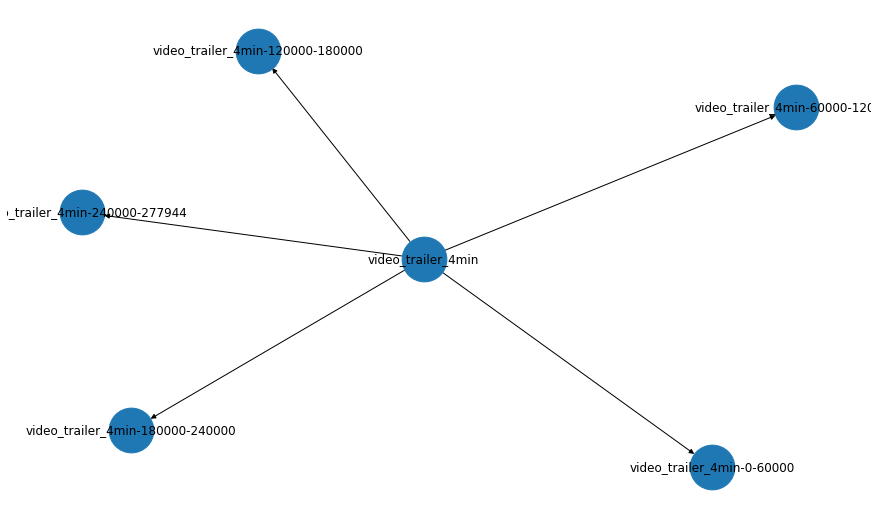

In [17]:
#please note that we limit the number of nodes being displayed
print_graph(V_VIDEO, video_name, [E_HAS_SEGMENT], node_limit=15)

# Add the scenes into our graph

In the below steps we're connecting the scenes to the video itself and not the segments as we want to be able to search and list the different types of scenes at the video level. However, note that we're not going to attach any specific metadata at the scene level, only at the segment level.

In [18]:
def store_video_segment(original_video_name, json_segment_detection_output, orig_video_vertex):
    
    shot_counter = 0
    tech_cue_counter = 0
    
    for technicalCue in json_segment_detection_output['Segments']:
        #start
        frameStartValue = technicalCue['StartTimestampMillis'] / 1000
        #end
        frameEndValue = technicalCue['EndTimestampMillis'] / 1000
        
        #SHOT or TECHNICAL_CUE
        segment_type = technicalCue['Type']
        
        counter = -1
        if (segment_type == 'SHOT'):
            shot_counter += 1
            counter = shot_counter
        elif (segment_type == 'TECHNICAL_CUE'):
            tech_cue_counter += 1
            counter = tech_cue_counter

        segment_id = original_video_name + '-' + segment_type + '-' + str(counter)
        
        #creating the vertex for the video segment with all the metadata extracted from the segment generation job
        new_vert = g.addV(V_VIDEO_SCENE).property("name", segment_id).property("type", segment_type) \
                            .property('StartTimestampMillis', technicalCue['StartTimestampMillis']).property('EndTimestampMillis', technicalCue['EndTimestampMillis']) \
                            .property('StartFrameNumber', technicalCue['StartFrameNumber']).property('EndFrameNumber', technicalCue['EndFrameNumber']) \
                            .property('DurationFrames', technicalCue['DurationFrames']).next()
    
        #creating the edge between the original video vertex and the segment vertex with the type as a property of the relationship
        g.V(orig_video_vertex).addE(E_HAS_SCENE).to(new_vert).properties("type", segment_type).iterate()

In [19]:
store_video_segment(video_name, SegmentDetectionOutput, sample_video_vertex)

[QUERY] We're retrieving the list of edges/branches created between the video and the scenes.


Explanation: g.V() returns all vertices, .has(V_VIDEO, 'name', video_name) returns the V_VIDEO vertex with name=video_name, .out(E_HAS_SCENE) returns the list of vertices that are connected to the V_VIDEO vertex by a E_HAS_SCENE edge, toList() returns the list of items.

In [20]:
list_of_edges = g.V().has(V_VIDEO, 'name', video_name).out(E_HAS_SCENE).toList()
print(f"the sample video vertex has now {len(list_of_edges)} edges connecting to the scenes vertices")

the sample video vertex has now 133 edges connecting to the scenes vertices


[QUERY] Let's search for the technical cues (black and fix screens) at the end of the video.

Explanation: g.V() returns all vertices, .has(V_VIDEO, 'name', video_name) returns the V_VIDEO vertex with name=video_name, .out(E_HAS_SCENE) returns the list of vertices that are connected to the V_VIDEO vertex by a E_HAS_SCENE edge, .has('type', 'TECHNICAL_CUE') filters the list on type=TECHNICAL_CUE, the rest was seen above already.

In [21]:
g.V().has(V_VIDEO, 'name', video_name).out(E_HAS_SCENE) \
                            .has('type', 'TECHNICAL_CUE') \
                            .order().by('EndTimestampMillis', Order.desc) \
                            .limit(5).valueMap().toList() 

[{'StartFrameNumber': [0],
  'DurationFrames': [6664],
  'name': ['video_trailer_4min-TECHNICAL_CUE-1'],
  'StartTimestampMillis': [0],
  'EndTimestampMillis': [277944],
  'type': ['TECHNICAL_CUE'],
  'EndFrameNumber': [6664]},
 {'StartFrameNumber': [6062],
  'DurationFrames': [234],
  'name': ['video_trailer_4min-TECHNICAL_CUE-3'],
  'StartTimestampMillis': [252835],
  'EndTimestampMillis': [262595],
  'type': ['TECHNICAL_CUE'],
  'EndFrameNumber': [6296]},
 {'StartFrameNumber': [527],
  'DurationFrames': [118],
  'name': ['video_trailer_4min-TECHNICAL_CUE-2'],
  'StartTimestampMillis': [21980],
  'EndTimestampMillis': [26901],
  'type': ['TECHNICAL_CUE'],
  'EndFrameNumber': [645]}]

</br>
Let's print the graph for those newly created SCENE vertices

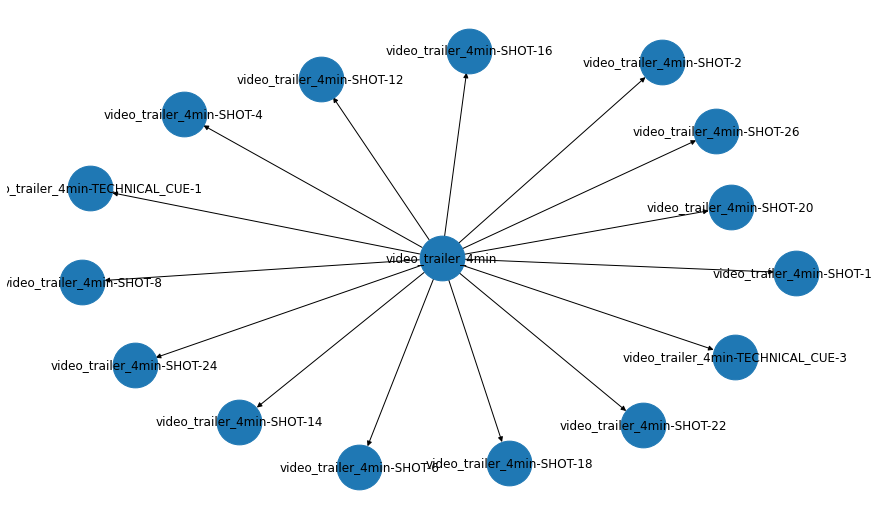

In [22]:
#please note that we limit the number of nodes being displayed
print_graph(V_VIDEO, video_name, [E_HAS_SCENE], node_limit=15)

## Create the labels vertices and link them to the segments
We're now going to create vertices to represent the labels in our graph and connect them to the 1min segments

In [23]:
def create_label_vertices(LabelDetectionOutput, video_name, g, confidence_threshold=80):

    labels = LabelDetectionOutput['Labels']
    
    for instance in labels:
        #keeping only the labels with high confidence
        label_details_obj = instance['Label']
        confidence = label_details_obj['Confidence']
        if confidence > confidence_threshold:
            
            #adding then main label name to the list
            label_name = str(label_details_obj['Name']).lower()
            
            #adding the label vertex
            add_vertex(V_LABEL, label_name, g)

            #adding the link between video and label
            add_edge(V_VIDEO, V_LABEL, video_name, label_name, E_HAS_LABEL, g, weight=None)
            
            
            #adding parent labels too
            parents = label_details_obj['Parents']
            if len(parents) > 0:
                for parent in parents:
                    #create parent vertex if it doesn't exist
                    parent_label_name = str(parent['Name']).lower()
                    add_vertex(V_LABEL, parent_label_name, g)
                    
                    #create the relationship between parent and children if it doesn't already exist
                    add_edge(V_LABEL, V_LABEL, parent_label_name, label_name, E_HAS_CHILD_LABEL, g, weight=None)
                 

In [24]:
create_label_vertices(LabelDetectionOutput, video_name, g, 80)

[QUERY] Let's list the labels vertices to see what was created above.

Explanation: g.V() returns all vertices, .hasLabel(V_LABEL) returns only the vertices of label/type V_LABEL, .valueMap().limit(20).toList() gives us the list with properties for the first 20 items.

In [25]:
#retrieving a list of the first 20 labels
label_list = g.V().hasLabel(V_LABEL).valueMap().limit(20).toList()
label_list

[{'name': ['apparel']},
 {'name': ['human']},
 {'name': ['plant']},
 {'name': ['outdoors']},
 {'name': ['shorts']},
 {'name': ['accessories']},
 {'name': ['face']},
 {'name': ['glasses']},
 {'name': ['shirt']},
 {'name': ['tie']},
 {'name': ['blonde']},
 {'name': ['girl']},
 {'name': ['teen']},
 {'name': ['halo']},
 {'name': ['nature']},
 {'name': ['interior design']},
 {'name': ['sash']},
 {'name': ['symbol']},
 {'name': ['trademark']},
 {'name': ['text']}]

Let's display a graph with our video's labels and the child labels relationships in between labels.

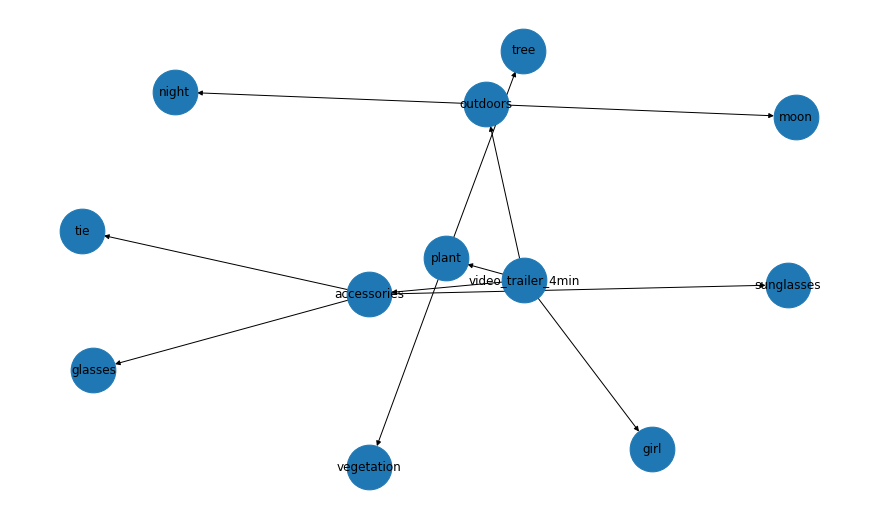

In [26]:
print_graph(V_VIDEO, video_name, [E_HAS_LABEL, E_HAS_CHILD_LABEL], node_limit=15)

[QUERY] A typical query would be to search for videos who have a specific label.

Explanation: g.V().has(V_LABEL, 'name', ..) returns the first label vertex from the previous computed list, .in_(E_HAS_LABEL) returns all vertices who have an incoming edge (inE) pointing to this label vertex, .valueMap().toList() returns the list with properties. 

note that in_(E_HAS_LABEL) is equivalent to .inE(E_HAS_LABEL).outV() where .inE(E_HAS_LABEL) returns all incoming edges with the specified label and .outV() will traverse to the vertices attached to that edge.

Obviously we only have the one result as we've only processed one video so far.

In [27]:
g.V().has(V_LABEL, 'name', label_list[0]['name'][0]).in_(E_HAS_LABEL).valueMap().toList()

[{'name': ['video_trailer_4min'],
  'description': ['description of the video'],
  'filename': ['video_trailer_4min.mp4']}]

## Create the topics and associated topic terms vertices
We are going to re-arrange a bit the raw results from the topic modeling job to make it more readable

In [28]:
comprehend_topics_df.head()

,docname,topic,proportion
0,video_transcript.csv:2,3,1.000000
1,video_transcript.csv:4,0,1.000000
2,video_transcript.csv:3,1,1.000000
3,video_transcript.csv:1,6,0.692798
4,video_transcript.csv:1,7,0.205275


We extract the segment id/number from the docname column in a separate column, cast it to numeric values, drop the docname column and sort by segment_id

In [29]:
comprehend_topics_df['segment_id'] = comprehend_topics_df['docname'].apply(lambda x: x.split(':')[-1])
comprehend_topics_df['segment_id'] = pd.to_numeric(comprehend_topics_df['segment_id'], errors='coerce')
comprehend_topics_df = comprehend_topics_df.drop('docname', axis=1)
comprehend_topics_df = comprehend_topics_df.sort_values(by='segment_id')

In [30]:
comprehend_topics_df.head(5)

,topic,proportion,segment_id
6,2,0.643991,0
7,5,0.205354,0
8,1,0.150655,0
3,6,0.692798,1
4,7,0.205275,1


Looks better!

Note that:
- a segment_id can belong to several topics
- proportion = the proportion of the document that is concerned with the topic

Let's now create our topic vertices

In [31]:
def create_topic_vertices(topics_df, terms_df, video_name, g):
    #retrieve all segments for the video
    segments_vertex_list = g.V().has(V_VIDEO, 'name', video_name).out(E_HAS_SEGMENT).order().by('StartTimestampMillis', Order.asc).valueMap().toList()
    
    for index, row in topics_df.iterrows():
        
        topic = row['topic']
        segment_id = int(row['segment_id'])
        
        #string formating to use as name for our vertices
        topic_str = str(int(row['topic']))
        
        #adding terms vertices that are associated with that topic and create the topic -> term edge
        list_of_terms = terms_df[comprehend_terms_df['topic'] == topic]
        
        #getting the segment name
        segment_name = segments_vertex_list[segment_id]['name'][0]
        
        #adding the topic vertex
        add_vertex(V_TOPIC, topic_str, g)
        
        #adding the link between entity and entity_type
        add_edge(V_VIDEO_SEGMENT, V_TOPIC, segment_name, topic_str, E_HAS_TOPIC, g, weight=None)
        
        
        
        #looping across all 
        for index2, row2 in list_of_terms.iterrows():
            term = row2['term']
            weight = row2['weight']
            add_vertex(V_TERM, term, g)
            add_edge(V_TOPIC, V_TERM, topic_str, term, E_HAS_TERM, g, weight=weight)

In [32]:
create_topic_vertices(comprehend_topics_df, comprehend_terms_df, video_name, g)

Let's display our video, few segments and their associated topics

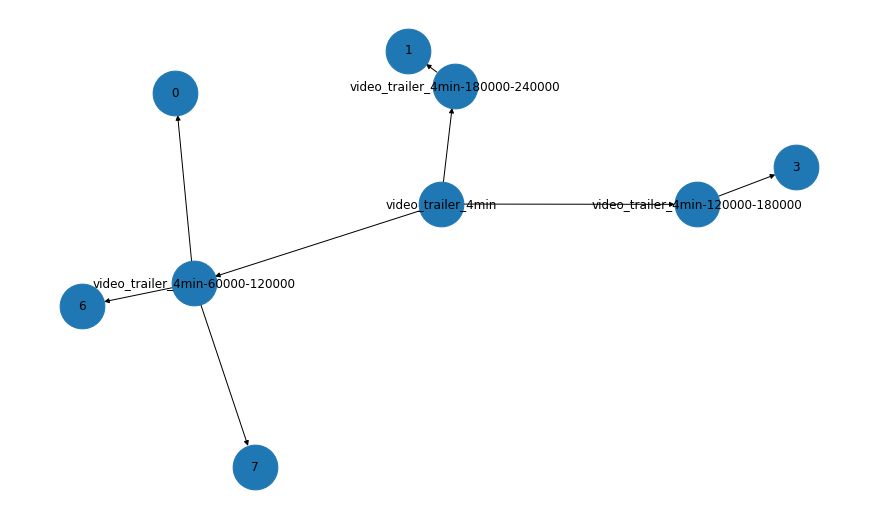

In [33]:
#please note that we limit the number of nodes being displayed
print_graph(V_VIDEO, video_name, [E_HAS_SEGMENT, E_HAS_TOPIC], node_limit=10)

Let's display a partial graph showing relationships between the video -> segment -> topic -> term

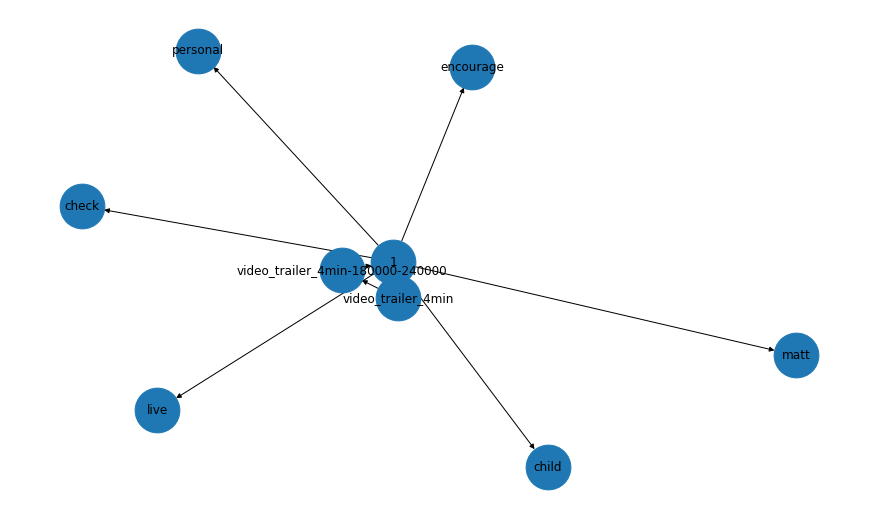

In [34]:
print_graph(V_VIDEO, video_name, [E_HAS_SEGMENT, E_HAS_TOPIC, E_HAS_TERM], node_limit=20)

[QUERY] We're now listing all the segments that are in topic 2 (try different topic numbers if you want)

Explanation: g.V().has(V_TOPIC, 'name', '2') returns the topic vertex with name=2, .in_(E_HAS_TOPIC) returns all vertices that have a edge pointing into that topic vertex, .valueMap().toList() returns the list of items with their properties

In [35]:
g.V().has(V_TOPIC, 'name', '2').in_(E_HAS_TOPIC).valueMap().toList()

[{'name': ['video_trailer_4min-0-60000'],
  'StartTimestampMillis': [0],
  'EndTimestampMillis': [60000]}]

## Create the NER vertices and link them to the segments

In [36]:
#create the entity and entity_type vertices including the related edges
def create_ner_vertices(ner_job_data, video_name, g, score_threshold=0.8):
    
    #retrieve all segments for the video
    segments_vertex_list = g.V().has(V_VIDEO, 'name', video_name).out(E_HAS_SEGMENT).order().by('StartTimestampMillis', Order.asc).valueMap().toList()
    counter_vertex = 0
    for doc in ner_job_data:
        
        #each jsonline from the ner job is already segmented by 1min chunks, so we're just matching them to our ordered segments list.
        segment_vertex_name = segments_vertex_list[counter_vertex]['name'][0]
        
        for entity in doc:
            
            text = entity['Text']
            type_ = entity['Type']
            score = entity['Score']

            if score > score_threshold:
                #adding the entity type vertex
                entity_type_vertex = g.V().has(V_ENTITY_TYPE,'name', type_).fold().coalesce(__.unfold(), __.addV(V_ENTITY_TYPE).property('name',type_)).iterate()

                #adding the entity type vertex
                entity_vertex = g.V().has(V_ENTITY,'name', text).fold().coalesce(__.unfold(), __.addV(V_ENTITY).property('name',text)).iterate()

                #adding the link between entity and entity_type
                entity_entity_type_edge = g.V().has(V_ENTITY_TYPE, 'name', type_).as_('v1').V().has(V_ENTITY, 'name', text).coalesce(__.outE(E_IS_OF_ENTITY_TYPE).where(__.inV().as_('v1')), __.addE(E_IS_OF_ENTITY_TYPE).to('v1')).iterate()
               
                #adding the edge between entity and segment
                segment_entity_edge = g.V().has(V_ENTITY,'name', text).as_('v1').V().has(V_VIDEO_SEGMENT, 'name', segment_vertex_name).coalesce(__.outE(E_HAS_ENTITY).where(__.inV().as_('v1')), __.addE(E_HAS_ENTITY).to('v1')).iterate()
                #print(f"attaching entity: {text} to segment: {segment_vertex_name}")

        counter_vertex += 1

In [37]:
create_ner_vertices(ner_job_data, video_name, g, 0.8)

[QUERY] Let's get a list of the first 20 entities

Explanation: g.V().hasLabel(V_ENTITY) returns all vertices of label/type V_ENTITY, .valueMap().limit(20).toList() returns the list of the first 20 items with their properties (just name in that case).

In [38]:
entities_list = g.V().hasLabel(V_ENTITY).valueMap().limit(20).toList()
entities_list

[{'name': ['Jamboree']},
 {'name': ['this year']},
 {'name': ['dr']},
 {'name': ['Prasad']},
 {'name': ['Mhm Education']},
 {'name': ['one']},
 {'name': ['1970s']},
 {'name': ['Carl Sagan']},
 {'name': ['every 60 years']},
 {'name': ['Christmas']},
 {'name': ['today']},
 {'name': ['Earth']},
 {'name': ['David Bowie']},
 {'name': ['Queen']},
 {'name': ['Vietnam war']},
 {'name': ['Nasa']},
 {'name': ['Troop Zero']},
 {'name': ['christmas']},
 {'name': ['carl Sagan']}]

[QUERY] Let's now look up the first entity of the previous entities_list and check its type

Explanation: g.V().has(V_ENTITY, 'name', ...) return the first V_ENTITY vertex of the entities_list list, .out(E_IS_OF_ENTITY_TYPE) returns vertices connected to this V_ENTITY vertex by a E_IS_OF_ENTITY_TYPE edge.

In [39]:
g.V().has(V_ENTITY, 'name', entities_list[0]['name'][0]).out(E_IS_OF_ENTITY_TYPE).valueMap().toList()

[{'name': ['EVENT']}]

[QUERY] Let's see now which video segments contains that entity

Explanation: g.V().has(V_ENTITY, 'name', ...) return the first V_ENTITY vertex of the entities_list list, .in_(E_HAS_ENTITY) returns all vertices that have an incoming edge into that V_ENTITY vertex and .valueMap().toList() returns the list with properties.

In [40]:
g.V().has(V_ENTITY, 'name', entities_list[0]['name'][0]).in_(E_HAS_ENTITY).valueMap().toList()

[{'name': ['video_trailer_4min-0-60000'],
  'StartTimestampMillis': [0],
  'EndTimestampMillis': [60000]},
 {'name': ['video_trailer_4min-180000-240000'],
  'StartTimestampMillis': [180000],
  'EndTimestampMillis': [240000]}]

[QUERY] Similar query but this time we traverse further the graph and only return the list of videos which have this specific entity.

Explanation: g.V().has(V_ENTITY, 'name', ...) return the first V_ENTITY vertex of the entities_list list, .in_(E_HAS_ENTITY) returns the V_VIDEO_SEGMENT vertices that have an incoming edge into that V_ENTITY vertex, .in_(E_HAS_SEGMENT) returns the V_VIDEO vertices that have an incoming edge into those V_VIDEO_SEGMENT vertices and .valueMap().toList() returns the list with properties.

Note how by chaining the .in_() methods we are able to traverse the graph from one type of vertex to the other.

In [41]:
g.V().has(V_ENTITY, 'name', entities_list[0]['name'][0]).in_(E_HAS_ENTITY).in_(E_HAS_SEGMENT).dedup().valueMap().toList()

[{'name': ['video_trailer_4min'],
  'description': ['description of the video'],
  'filename': ['video_trailer_4min.mp4']}]

</br>
Let's now display a graph showing the relationship between Video -> Segment -> Entity

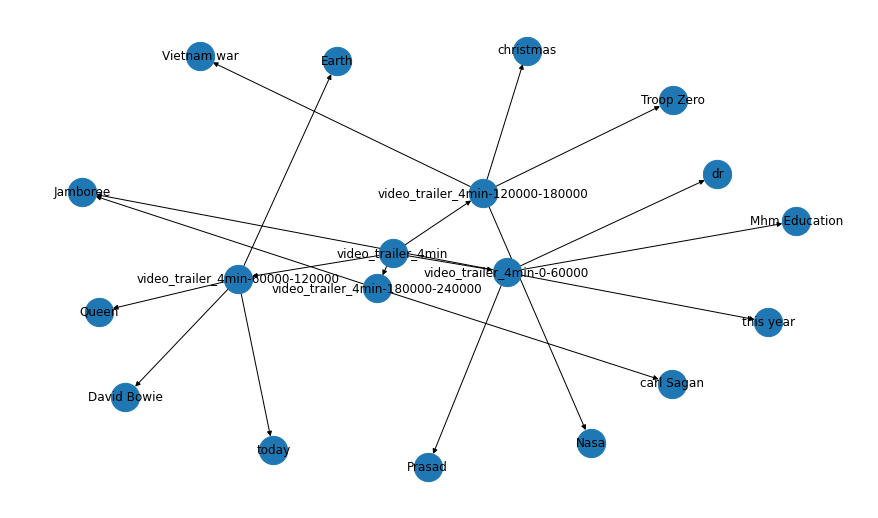

In [42]:
print_graph(V_VIDEO, video_name, [E_HAS_SEGMENT, E_HAS_ENTITY], node_size=800, node_limit=30)

# Summary

This notebook only touched the surface of what you can do with Graph databases but it should give you an idea of how powerful  they are at modeling highly dimensional relationships between entities. This specific architecture allows them to be especially scalable and performing even with billions of vertices and edges. 

Gremlin is the most widely used query language for graph DB and provides quite an intuitive way to traverse/query those graphs by chaining those instructions but if you want a more traditional SQL language, you can also look into SPARQL as an alternative. 
https://graphdb.ontotext.com/documentation/free/devhub/sparql.html#using-sparql-in-graphdb 